In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical analysis
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Machine learning (supervised learning)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

<h1>Load and Simple Analysis<h1>

In [ ]:
df = pd.read_excel("2021.xlsx")
df.head()

In [ ]:
# Check data types and non-null counts
print("Data Summary:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

In [ ]:
print("\nUnique Values per Column:")
for column in df.columns:
    print(f"\n{column}:")
    print(f"Unique Count: {df[column].nunique()}")
    print(f"First 10 Unique Values: {df[column].unique()[:10]}")

In [ ]:
# drop rows with missing values
clean_df = df.dropna(subset=['店铺名称', '品牌名称'])
print("\nCleaned Data Summary:")
print(clean_df.info())

In [ ]:
# Create a dictionary to map platform names
platform_mapping = {
    '抖音': 'Douyin',
    '京东': 'JD',
    '天猫': 'Tmall'
}

# Apply the mapping to the '一级平台' column
clean_df['Primary Platform'] = clean_df['一级平台'].map(platform_mapping)

In [ ]:
# Column name mapping dictionary
column_mapping = {
    '销售月份': 'Sales Month',
    '一级平台': 'Primary Platform (Original)',
    '二级平台': 'Secondary Platform',
    '店铺名称': 'Store Name',
    '品牌名称': 'Brand Name',
    '商品编码': 'Product Code',
    '销售金额': 'Sales Amount',
    '销售数量': 'Sales Quantity'
}

# Rename columns
clean_df = clean_df.rename(columns=column_mapping)

In [ ]:
# Split data by platform and save to CSV
platforms = clean_df['Primary Platform'].unique()

for platform in platforms:
    platform_data = clean_df[clean_df['Primary Platform'] == platform]
    platform_data.to_csv(f'{platform}_sales_data.csv', index=False)

<h1>Douyin Analysis</h1>


Missing Values in Douyin Data:
Sales Month                    0
Primary Platform (Original)    0
Secondary Platform             0
Store Name                     0
Brand Name                     0
Product Code                   0
Sales Amount                   0
Sales Quantity                 0
Primary Platform               0
dtype: int64


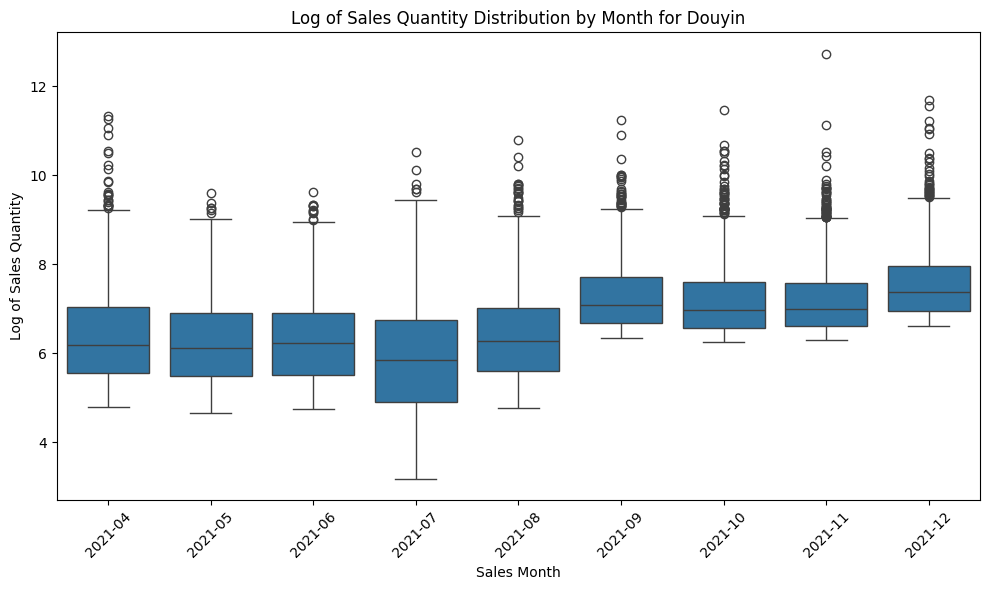

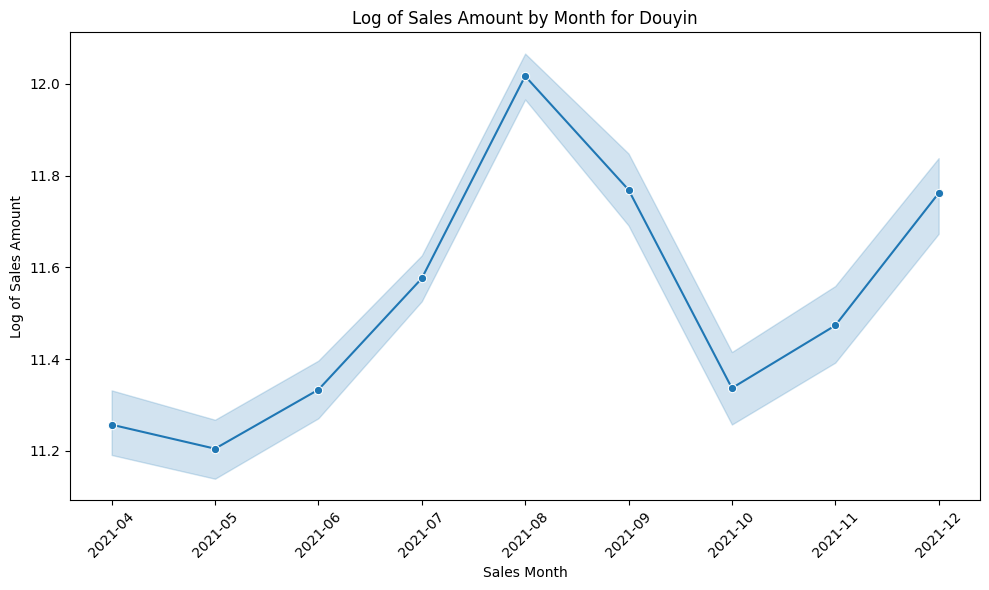

In [48]:
dy_df = pd.read_csv('Douyin_sales_data.csv')
# Check for missing values in Douyin data
print("\nMissing Values in Douyin Data:")
print(dy_df.isnull().sum())
# Visualize log of sales quantity distribution by month for Douyin
plt.figure(figsize=(10, 6))
sns.boxplot(data=dy_df, x='Sales Month', y=np.log1p(dy_df['Sales Quantity']))
plt.title('Log of Sales Quantity Distribution by Month for Douyin')
plt.xlabel('Sales Month')
plt.ylabel('Log of Sales Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
# Visualize log sales amount by month for Douyin
plt.figure(figsize=(10, 6))
sns.lineplot(data=dy_df, x='Sales Month', y=np.log1p(dy_df['Sales Amount']), marker='o')
plt.title('Log of Sales Amount by Month for Douyin')
plt.xlabel('Sales Month')
plt.ylabel('Log of Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()

In [49]:
def categorize_store(store_name):
    if '官方旗舰店' in store_name:
        return 'Official Flagship'
    elif '卖场旗舰店' in store_name:
        return 'Mall Flagship'
    elif '旗舰店' in store_name:
        return 'Flagship'
    elif '专卖店' in store_name or '专营店' in store_name:
        return 'Specialty Store'
    elif '卖场店' in store_name:
        return 'Mall Store'
    else:
        return 'Other'

# Apply categorization
dy_df['Store Type'] = dy_df['Store Name'].apply(categorize_store)

In [50]:
print(dy_df['Store Type'].value_counts())

Store Type
Specialty Store      9082
Official Flagship    1566
Mall Flagship        1402
Flagship             1053
Mall Store            213
Other                 184
Name: count, dtype: int64


In [51]:
dy_df.columns.tolist()

['Sales Month',
 'Primary Platform (Original)',
 'Secondary Platform',
 'Store Name',
 'Brand Name',
 'Product Code',
 'Sales Amount',
 'Sales Quantity',
 'Primary Platform',
 'Store Type']

In [52]:
dy_df['Store_ID'] =  dy_df['Store Name'] + '_' + dy_df['Brand Name']
dy_df = dy_df.sort_values(by=['Store_ID', 'Sales Month']).reset_index(drop=True)
for lag in [1, 2, 3]:
    dy_df[f'Sales Lag {lag}'] = dy_df.groupby('Store_ID')['Sales Quantity'].shift(lag)
dy_df['Sales Rolling Mean'] = dy_df.groupby('Store_ID')['Sales Quantity'].transform(
    lambda x: x.rolling(3).mean()
)
dy_df.fillna(0, inplace=True)  # Replace NaN with 0

In [53]:
# Encode categorical variables (e.g., 'Store Type') - keep all categories
encoder = OneHotEncoder(sparse_output=False, drop=None)  # Changed from drop='first'
store_type_encoded = encoder.fit_transform(dy_df[['Store Type']])
store_type_df = pd.DataFrame(store_type_encoded, columns=encoder.get_feature_names_out(['Store Type']))
dy_df = pd.concat([dy_df, store_type_df], axis=1)

Correlation Matrix:
                     Sales Quantity  Sales Lag 1  Sales Lag 2  Sales Lag 3  \
Sales Quantity            1.000000     0.197065     0.127331     0.083656   
Sales Lag 1               0.197065     1.000000     0.206195     0.138121   
Sales Lag 2               0.127331     0.206195     1.000000     0.212798   
Sales Lag 3               0.083656     0.138121     0.212798     1.000000   
Sales Rolling Mean        0.550145     0.648776     0.697412     0.239561   

                    Sales Rolling Mean  
Sales Quantity                0.550145  
Sales Lag 1                   0.648776  
Sales Lag 2                   0.697412  
Sales Lag 3                   0.239561  
Sales Rolling Mean            1.000000  


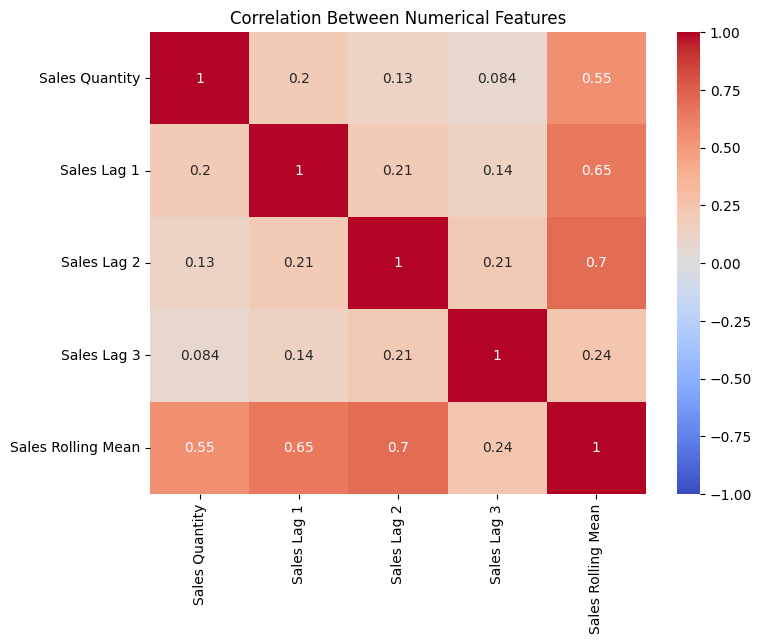

In [54]:
# Calculate Pearson correlation
corr_matrix = dy_df[['Sales Quantity', 'Sales Lag 1', 'Sales Lag 2', 'Sales Lag 3', 'Sales Rolling Mean']].corr()
print("Correlation Matrix:\n", corr_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Numerical Features')
plt.show()

Mean Squared Error: 47887310.19
R² Score: -2.242
Feature Importances: [1.64689348e-02 1.27413491e-03 4.43140472e-03 5.26372365e-04
 6.88794189e-04 2.68915224e-03 3.35323004e-03 2.47660406e-01
 3.83770641e-02 8.60611465e-03 6.75924392e-01]


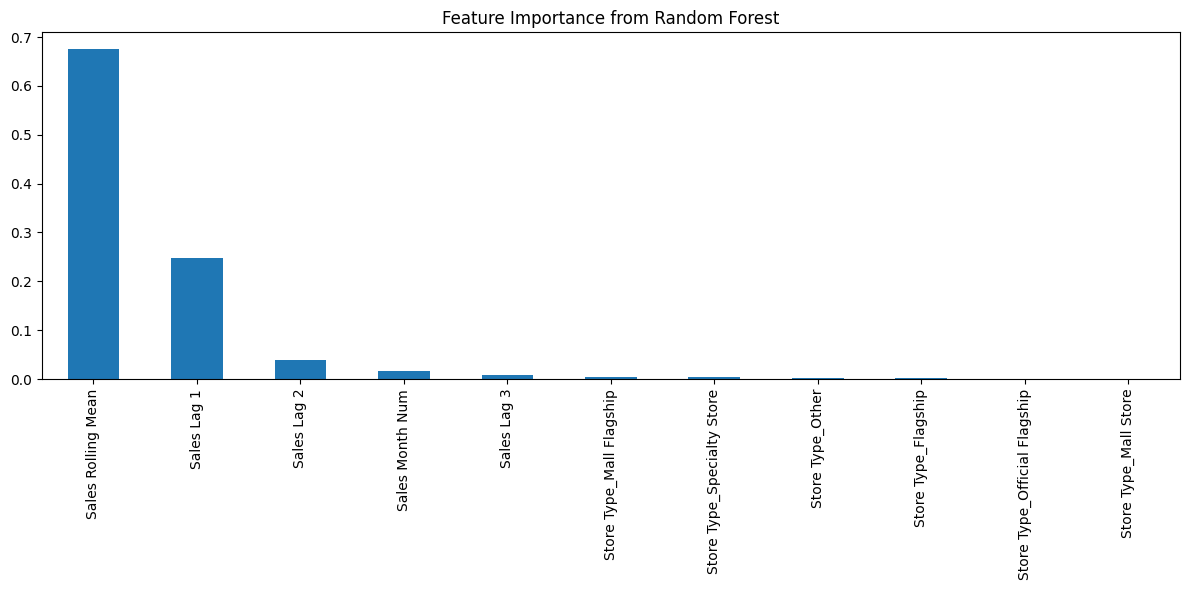

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare features (encode categorical variables)
features = [
    'Sales Month Num',  # Use the numerical version we created
    # 'is_official',
    'Store Type_Flagship',
    'Store Type_Mall Flagship', 
    'Store Type_Mall Store', 
    'Store Type_Official Flagship', 
    'Store Type_Other', 
    'Store Type_Specialty Store',  # Added missing comma here
    'Sales Lag 1',
    'Sales Lag 2',
    'Sales Lag 3',
    'Sales Rolling Mean',
    # Note: Removed 'Brand Name' for now since it has many categories and would need encoding
]

# Convert 'Sales Month' to numerical (e.g., month number)
dy_df['Sales Month Num'] = pd.to_datetime(dy_df['Sales Month']).dt.month

# Split data
X = dy_df[features]
y = dy_df['Sales Quantity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.3f}")
print(f"Feature Importances: {rf.feature_importances_}")

# Feature importance
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numerical features
numerical_features = [
    'Sales Month Num',  # Use the numerical version we created
    # 'is_official',
    'Store Type_Flagship',
    'Store Type_Mall Flagship', 
    'Store Type_Mall Store', 
    'Store Type_Official Flagship', 
    'Store Type_Other', 
    'Store Type_Specialty Store',
    'Sales Lag 1',
    'Sales Lag 2',
    'Sales Lag 3',
    'Sales Rolling Mean',
]
vif_data = dy_df[numerical_features]

vif = pd.DataFrame()
vif["Feature"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_data.columns))]
print("\nVIF Scores:\n", vif)


VIF Scores:
                          Feature       VIF
0                Sales Month Num  1.068769
1            Store Type_Flagship  1.744644
2       Store Type_Mall Flagship  1.808645
3          Store Type_Mall Store  1.154288
4   Store Type_Official Flagship  2.053852
5               Store Type_Other  1.173398
6     Store Type_Specialty Store  7.942149
7                    Sales Lag 1  2.171484
8                    Sales Lag 2  2.459845
9                    Sales Lag 3  1.071581
10            Sales Rolling Mean  4.141972


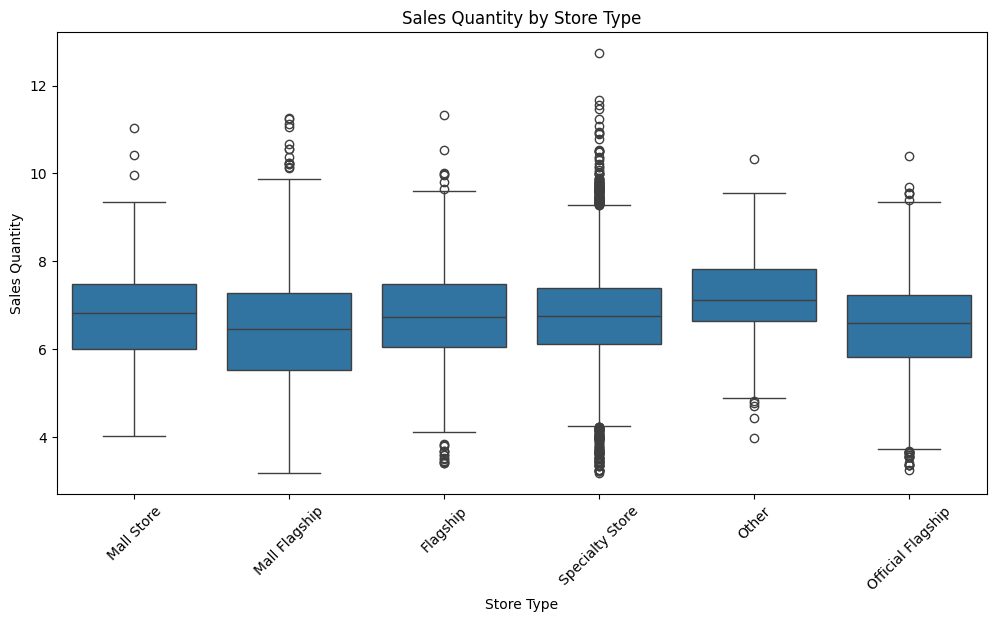

In [61]:
# -- log sales quantity by store type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store Type', y=np.log1p(dy_df['Sales Quantity']), data=dy_df)
plt.title('Sales Quantity by Store Type')
plt.xticks(rotation=45)
plt.show()

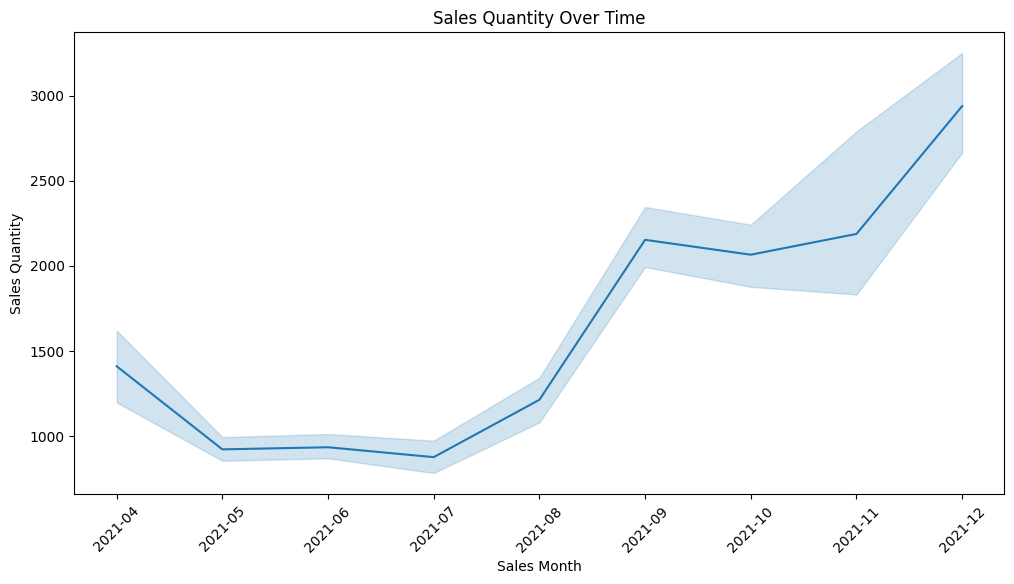

In [63]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Sales Month', y='Sales Quantity', data=dy_df)
plt.title('Sales Quantity Over Time')
plt.xticks(rotation=45)
plt.show()

In [64]:
# ------- Feature Engineering --------- #
# Convert 'Sales Month' to categorical dummies
dy_df = pd.get_dummies(dy_df, columns=['Sales Month'])

In [65]:
from category_encoders import TargetEncoder

# Initialize TargetEncoder
te = TargetEncoder(smoothing=1.0)  # Smoothing to handle rare brands

# Fit and transform
dy_df['Brand Name Encoded'] = te.fit_transform(
    dy_df['Brand Name'], 
    dy_df['Sales Quantity']
)

# Get top brands and create binary indicator
top_brands = dy_df['Brand Name'].value_counts().head(5).index
print("\nTop Brands:")
print(top_brands)

# Create binary indicator for top brands
dy_df['is_top'] = dy_df['Brand Name'].isin(top_brands).astype(int)

# Check the distribution
print(f"\nTop brand distribution:")
print(dy_df['is_top'].value_counts())


Top Brands:
Index(['其他', '五粮液', '茅台', '白水杜康', '汾酒'], dtype='object', name='Brand Name')

Top brand distribution:
is_top
1    9000
0    4500
Name: count, dtype: int64


In [66]:
# Create is_promote column based on promotional periods using Sales Month Num
def is_promotional_period_num(month_num):
    """
    Determine if a sales month (numeric) falls within a promotional period.
    Promotional months: 1, 6, 9, 11, 12
    """
    promotional_months = [1, 6, 9, 11, 12]
    return 1 if month_num in promotional_months else 0

# Apply the function to create is_promote column
dy_df['is_promote'] = dy_df['Sales Month Num'].apply(is_promotional_period_num)

# Check the distribution
print("Promotional period distribution:")
print(dy_df['is_promote'].value_counts())

# Show breakdown by month
print("\nPromotional periods by month:")
promotion_by_month = dy_df.groupby('Sales Month Num')['is_promote'].first().sort_index()
print(promotion_by_month)

Promotional period distribution:
is_promote
0    7500
1    6000
Name: count, dtype: int64

Promotional periods by month:
Sales Month Num
4     0
5     0
6     1
7     0
8     0
9     1
10    0
11    1
12    1
Name: is_promote, dtype: int64


In [67]:
final_features = [
    # Store Type (already one-hot encoded)
    'Store Type_Flagship',
    'Store Type_Mall Flagship', 
    'Store Type_Mall Store', 
    'Store Type_Official Flagship', 
    'Store Type_Other', 
    'Store Type_Specialty Store',
    
    # Brand Features
    'Brand Name Encoded', 
    'is_top',
    
    # Time Features (seasonality)
    'Sales Month_2021-04',
    'Sales Month_2021-05', 
    'Sales Month_2021-06', 
    'Sales Month_2021-07', 
    'Sales Month_2021-08', 
    'Sales Month_2021-09', 
    'Sales Month_2021-10', 
    'Sales Month_2021-11', 
    'Sales Month_2021-12',
    'is_promote',
    'Sales Lag 1',
    'Sales Lag 2',
    'Sales Lag 3',
    'Sales Rolling Mean',
]

In [82]:
print(dy_df['brand_store_interaction'])

0        0.0
4172     0.0
9445     0.0
12023    0.0
9444     0.0
        ... 
4352     0.0
4351     0.0
4350     0.0
4362     0.0
13499    0.0
Name: brand_store_interaction, Length: 13500, dtype: float64


In [81]:
# Check for data quality issues
print("Sales Quantity distribution:")
print(dy_df['Sales Quantity'].describe())
print(f"Zero sales records: {(dy_df['Sales Quantity'] == 0).sum()}")
print(f"Negative sales records: {(dy_df['Sales Quantity'] < 0).sum()}")

# Check prediction distribution
print("Prediction vs Actual comparison:")
print(f"Actual range: {y_test.min():.0f} - {y_test.max():.0f}")
print(f"Predicted range: {y_test_pred.min():.0f} - {y_test_pred.max():.0f}")

Sales Quantity distribution:
count     13500.00000
mean       1631.79800
std        4569.14827
min          23.00000
25%         412.00000
50%         819.50000
75%        1602.00000
max      340034.00000
Name: Sales Quantity, dtype: float64
Zero sales records: 0
Negative sales records: 0
Prediction vs Actual comparison:
Actual range: 24 - 83879
Predicted range: 387 - 2536


In [68]:
# Drop excluded columns for column names not in final_features and not Sales Quantity
dy_df = dy_df[final_features + ['Sales Quantity']]

In [69]:
dy_df.to_csv('processed_douyin_sales_data.csv', index=False)

<h1>Douyin Sales Quantity Prediction</h1>

<h3>Baseline: XGBoost

In [83]:
dy_df = pd.read_csv('processed_douyin_sales_data.csv')

dy_df['Sales Month'] = dy_df[['Sales Month_2021-04',
                             'Sales Month_2021-05',
                             'Sales Month_2021-06',
                             'Sales Month_2021-07',
                             'Sales Month_2021-08',
                             'Sales Month_2021-09',
                             'Sales Month_2021-10',
                             'Sales Month_2021-11',
                             'Sales Month_2021-12']].idxmax(axis=1)
# Remove the 'Sales Month_' prefix to get just the date
dy_df['Sales Month'] = dy_df['Sales Month'].str.replace('Sales Month_', '')

print(dy_df['Sales Month'].value_counts())

Sales Month
2021-04    1500
2021-05    1500
2021-06    1500
2021-07    1500
2021-08    1500
2021-09    1500
2021-10    1500
2021-11    1500
2021-12    1500
Name: count, dtype: int64


In [88]:
# Check what columns are available in your DataFrame
print("Available columns in dy_df:")
print(dy_df.columns.tolist())
print("\nFirst few rows to understand structure:")
print(dy_df.head())

# Fixed cyclical time features function
def add_cyclical_features(df):
    """Add cyclical encoding for months"""
    df = df.copy()
    # Convert month to numeric (4=April, 5=May, etc.)
    df['month_num'] = df['Sales Month'].str.extract('(\d+)').astype(int)
    df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)
    return df

# Alternative trend features - since we don't have Store Name, we'll create a store identifier
def add_trend_features(df):
    """Add percentage change features using available store identifiers"""
    df = df.copy()
    
    # Create a store identifier using store type and brand combination
    # This assumes each combination represents a unique store
    store_type_cols = ['Store Type_Flagship', 'Store Type_Mall Flagship', 'Store Type_Mall Store', 
                      'Store Type_Official Flagship', 'Store Type_Other', 'Store Type_Specialty Store']
    
    # Find which store type is active (value = 1.0)
    df['store_type'] = df[store_type_cols].idxmax(axis=1)
    
    # Create composite store identifier
    df['store_id'] = df['store_type'].astype(str) + '_' + df['Brand Name Encoded'].astype(str)
    
    # Sort by store_id and Sales Month for proper time series ordering
    df_sorted = df.sort_values(['store_id', 'Sales Month'])
    
    # Calculate percentage change within each store
    df_sorted['sales_pct_change'] = df_sorted.groupby('store_id')['Sales Quantity'].pct_change()
    df_sorted['sales_pct_change'] = df_sorted['sales_pct_change'].fillna(0)
    
    # Replace infinite values with 0 (in case of division by zero)
    df_sorted['sales_pct_change'] = df_sorted['sales_pct_change'].replace([np.inf, -np.inf], 0)
    
    # Drop the temporary columns we created for identification
    df_sorted = df_sorted.drop(['store_type', 'store_id'], axis=1)
    
    return df_sorted

# Safe feature addition with error handling
def safe_add_features(df):
    """Safely add all new features with error handling"""
    try:
        print("Adding brand-store interaction...")
        df['brand_store_interaction'] = df['Brand Name Encoded'] * df['Store Type_Official Flagship']
        print("✓ Brand-Store Interaction Feature Created")
        
        print("Adding cyclical time features...")
        df = add_cyclical_features(df)
        print("✓ Cyclical Features Added")
        
        print("Adding trend features...")
        df = add_trend_features(df)
        print("✓ Trend Features Added")
        
        print("\nNew features created:")
        new_features = ['brand_store_interaction', 'month_num', 'month_sin', 'month_cos', 'sales_pct_change']
        for feature in new_features:
            if feature in df.columns:
                print(f"  - {feature}: {df[feature].dtype}")
        
        return df
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        print("Please check your DataFrame structure and column names.")
        return df

# Apply the feature engineering
dy_df_enhanced = safe_add_features(dy_df)

# Check for any issues with the new features
print("\nFeature quality check:")
for feature in ['brand_store_interaction', 'month_sin', 'month_cos', 'sales_pct_change']:
    if feature in dy_df_enhanced.columns:
        print(f"{feature}:")
        print(f"  - Shape: {dy_df_enhanced[feature].shape}")
        print(f"  - Missing values: {dy_df_enhanced[feature].isnull().sum()}")
        print(f"  - Range: [{dy_df_enhanced[feature].min():.4f}, {dy_df_enhanced[feature].max():.4f}]")
        print(f"  - Mean: {dy_df_enhanced[feature].mean():.4f}")
        print()

# Updated feature list with new features (removing problematic ones)
refined_features = [
    # Store Type (keep most important ones, remove high VIF)
    'Store Type_Mall Flagship', 
    'Store Type_Official Flagship', 
    'Store Type_Other', 
    # Removed 'Store Type_Specialty Store' due to high VIF
    
    # Brand Features
    'Brand Name Encoded', 
    'is_top',
    
    # Promotional feature
    'is_promote',
    
    # Temporal Features - keep only the most predictive
    'Sales Lag 1',  # Keep this (correlation: 0.197)
    # Removed Sales Lag 2, 3 and Rolling Mean due to multicollinearity
    
    # New cyclical time features
    'month_sin',
    'month_cos',
    
    # New interaction and trend features
    'brand_store_interaction',
    'sales_pct_change'
]

print("Refined feature list:")
for i, feature in enumerate(refined_features, 1):
    print(f"{i:2d}. {feature}")

# Verify all features exist in the enhanced DataFrame
missing_features = [f for f in refined_features if f not in dy_df_enhanced.columns]
if missing_features:
    print(f"\nWarning: Missing features: {missing_features}")
else:
    print(f"\n✓ All {len(refined_features)} refined features are available!")

Available columns in dy_df:
['Store Type_Flagship', 'Store Type_Mall Flagship', 'Store Type_Mall Store', 'Store Type_Official Flagship', 'Store Type_Other', 'Store Type_Specialty Store', 'Brand Name Encoded', 'is_top', 'Sales Month_2021-04', 'Sales Month_2021-05', 'Sales Month_2021-06', 'Sales Month_2021-07', 'Sales Month_2021-08', 'Sales Month_2021-09', 'Sales Month_2021-10', 'Sales Month_2021-11', 'Sales Month_2021-12', 'is_promote', 'Sales Lag 1', 'Sales Lag 2', 'Sales Lag 3', 'Sales Rolling Mean', 'Sales Quantity', 'Sales Month', 'brand_store_interaction', 'month_num', 'month_sin', 'month_cos']

First few rows to understand structure:
   Store Type_Flagship  Store Type_Mall Flagship  Store Type_Mall Store  \
0                  0.0                       0.0                    1.0   
1                  0.0                       1.0                    0.0   
2                  0.0                       1.0                    0.0   
3                  0.0                       1.0     

In [89]:
# Test the refined model with new features
print("=== REFINED MODEL TESTING ===")

# The refined features list (as defined earlier)
refined_features = [
    'Store Type_Mall Flagship', 
    'Store Type_Official Flagship', 
    'Store Type_Other', 
    'Brand Name Encoded', 
    'is_top',
    'is_promote',
    'Sales Lag 1',
    'month_sin',
    'month_cos',
    'brand_store_interaction',
    'sales_pct_change'
]

# Split the enhanced data using the same month-based approach
train_months = ['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10']
val_month = ['2021-11']
test_months = ['2021-12']

train_df_enh = dy_df_enhanced[dy_df_enhanced['Sales Month'].isin(train_months)]
val_df_enh = dy_df_enhanced[dy_df_enhanced['Sales Month'].isin(val_month)]
test_df_enh = dy_df_enhanced[dy_df_enhanced['Sales Month'].isin(test_months)]

print(f"Enhanced Training set size: {len(train_df_enh)}")
print(f"Enhanced Validation set size: {len(val_df_enh)}")
print(f"Enhanced Test set size: {len(test_df_enh)}")

# Prepare training data with refined features
X_train_ref = train_df_enh[refined_features]
y_train_ref = train_df_enh['Sales Quantity']

X_val_ref = val_df_enh[refined_features]
y_val_ref = val_df_enh['Sales Quantity']

X_test_ref = test_df_enh[refined_features]
y_test_ref = test_df_enh['Sales Quantity']

# Check for any missing values in refined features
print("\n=== DATA QUALITY CHECK ===")
for feature in refined_features:
    missing_count = X_train_ref[feature].isnull().sum()
    if missing_count > 0:
        print(f"WARNING: {feature} has {missing_count} missing values")
    
# Fill any remaining missing values
X_train_ref = X_train_ref.fillna(0)
X_val_ref = X_val_ref.fillna(0)
X_test_ref = X_test_ref.fillna(0)

print("✓ Missing values handled")

# Train refined XGBoost model
print("\n=== TRAINING REFINED MODEL ===")
model_refined = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0  # Reduce output noise
)

model_refined.fit(X_train_ref, y_train_ref)
print("✓ Model training completed")

# Make predictions
y_val_pred_ref = model_refined.predict(X_val_ref)
y_test_pred_ref = model_refined.predict(X_test_ref)

# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Validation metrics
val_mape_ref = calculate_mape(y_val_ref, y_val_pred_ref)
val_mae_ref = mean_absolute_error(y_val_ref, y_val_pred_ref)
val_r2_ref = r2_score(y_val_ref, y_val_pred_ref)

# Test metrics
test_mape_ref = calculate_mape(y_test_ref, y_test_pred_ref)
test_mae_ref = mean_absolute_error(y_test_ref, y_test_pred_ref)
test_r2_ref = r2_score(y_test_ref, y_test_pred_ref)

print("\n=== REFINED MODEL PERFORMANCE ===")
print(f"Validation Metrics:")
print(f"  MAPE: {val_mape_ref:.2f}%")
print(f"  MAE:  {val_mae_ref:.2f}")
print(f"  R²:   {val_r2_ref:.4f}")

print(f"\nTest Metrics:")
print(f"  MAPE: {test_mape_ref:.2f}%")
print(f"  MAE:  {test_mae_ref:.2f}")
print(f"  R²:   {test_r2_ref:.4f}")

# Compare with original model performance
print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Original Model:")
print(f"  Validation MAPE: 50.49%")
print(f"  Test MAPE: 45.25%")
print(f"  R²: -2.242")

print(f"\nRefined Model:")
print(f"  Validation MAPE: {val_mape_ref:.2f}%")
print(f"  Test MAPE: {test_mape_ref:.2f}%")
print(f"  R²: {test_r2_ref:.4f}")

# Improvement calculation
val_improvement = 50.49 - val_mape_ref
test_improvement = 45.25 - test_mape_ref

print(f"\nImprovement:")
print(f"  Validation: {val_improvement:.2f} percentage points better")
print(f"  Test: {test_improvement:.2f} percentage points better")

# Feature importance analysis
print(f"\n=== REFINED MODEL FEATURE IMPORTANCE ===")
importance_ref = pd.Series(model_refined.feature_importances_, index=refined_features)
importance_ref_sorted = importance_ref.sort_values(ascending=False)

for i, (feature, importance) in enumerate(importance_ref_sorted.items(), 1):
    print(f"{i:2d}. {feature:<25} {importance:.4f}")

# Check if model meets requirements
print(f"\n=== REQUIREMENT CHECK ===")
print("Third-party requirements:")
print("  - ≤5%:  Excellent")
print("  - ≤10%: Usable") 
print("  - ≤20%: Barely usable")
print("  - >20%: Poor reference value")

test_status = ""
if test_mape_ref <= 5:
    test_status = "✅ EXCELLENT"
elif test_mape_ref <= 10:
    test_status = "✅ USABLE"
elif test_mape_ref <= 20:
    test_status = "⚠️  BARELY USABLE"
else:
    test_status = "❌ POOR"

print(f"\nCurrent Test MAPE: {test_mape_ref:.2f}% - {test_status}")

# Prediction distribution analysis
print(f"\n=== PREDICTION ANALYSIS ===")
print(f"Actual values (test set):")
print(f"  Range: {y_test_ref.min():.0f} to {y_test_ref.max():.0f}")
print(f"  Mean:  {y_test_ref.mean():.0f}")
print(f"  Std:   {y_test_ref.std():.0f}")

print(f"\nPredicted values (test set):")
print(f"  Range: {y_test_pred_ref.min():.0f} to {y_test_pred_ref.max():.0f}")
print(f"  Mean:  {y_test_pred_ref.mean():.0f}")
print(f"  Std:   {y_test_pred_ref.std():.0f}")

# Check for negative predictions
negative_preds = (y_test_pred_ref < 0).sum()
if negative_preds > 0:
    print(f"\n⚠️  Warning: {negative_preds} negative predictions detected")
else:
    print(f"\n✅ No negative predictions")

print("\n" + "="*50)
print("SUMMARY: Refined model testing completed!")

=== REFINED MODEL TESTING ===
Enhanced Training set size: 10500
Enhanced Validation set size: 1500
Enhanced Test set size: 1500

=== DATA QUALITY CHECK ===
✓ Missing values handled

=== TRAINING REFINED MODEL ===
✓ Model training completed

=== REFINED MODEL PERFORMANCE ===
Validation Metrics:
  MAPE: 24.40%
  MAE:  756.93
  R²:   0.2217

Test Metrics:
  MAPE: 22.12%
  MAE:  1050.87
  R²:   0.3213

=== PERFORMANCE COMPARISON ===
Original Model:
  Validation MAPE: 50.49%
  Test MAPE: 45.25%
  R²: -2.242

Refined Model:
  Validation MAPE: 24.40%
  Test MAPE: 22.12%
  R²: 0.3213

Improvement:
  Validation: 26.09 percentage points better
  Test: 23.13 percentage points better

=== REFINED MODEL FEATURE IMPORTANCE ===
 1. sales_pct_change          0.2523
 2. Sales Lag 1               0.2097
 3. Brand Name Encoded        0.1167
 4. Store Type_Mall Flagship  0.1094
 5. is_top                    0.1018
 6. is_promote                0.0725
 7. Store Type_Official Flagship 0.0719
 8. brand_store

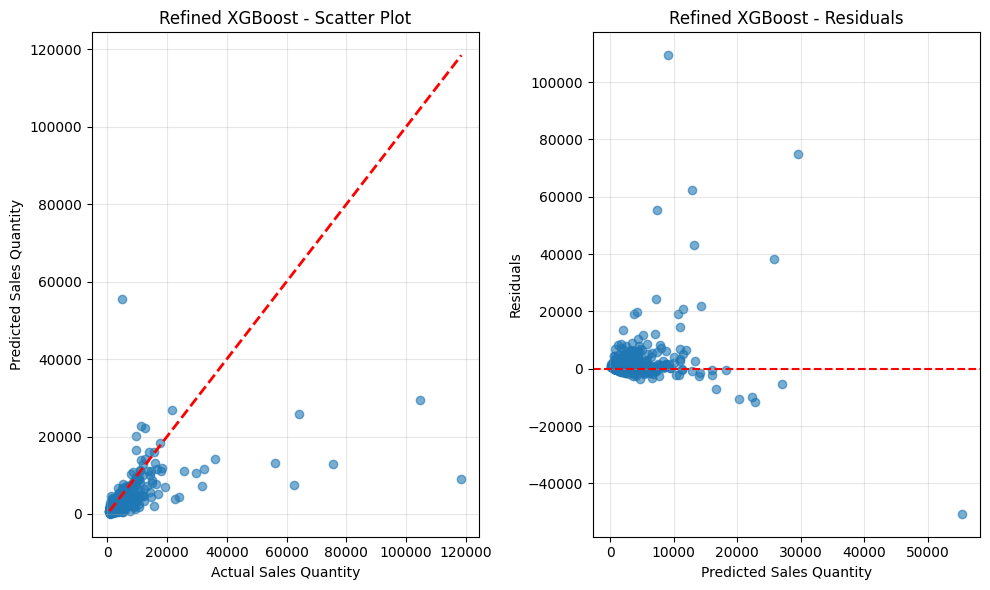

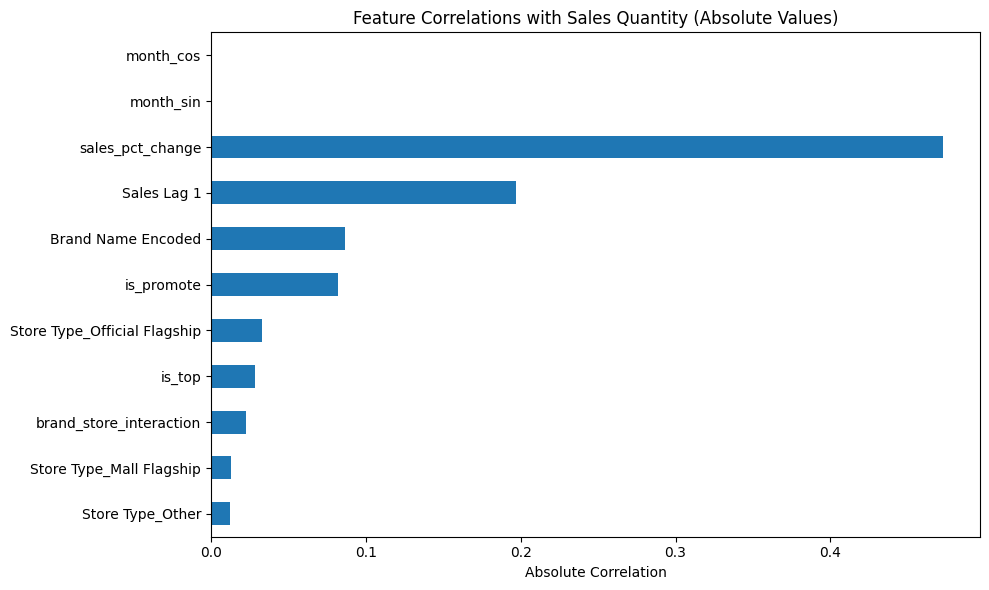

Feature correlations with Sales Quantity:
sales_pct_change               0.4730
Sales Lag 1                    0.1971
Brand Name Encoded             0.0865
is_promote                     0.0823
Store Type_Official Flagship   0.0327
is_top                         0.0284
brand_store_interaction        0.0228
Store Type_Mall Flagship       0.0128
Store Type_Other               0.0124
month_sin                      nan
month_cos                      nan
=== ALTERNATIVE MODELS COMPARISON ===
Ridge Regression     MAPE:  57.22%  R²:  0.1608
ElasticNet           MAPE:  57.34%  R²:  0.1287
Random Forest        MAPE:  20.55%  R²:  0.2309
=== SALES PATTERN ANALYSIS ===

Monthly Sales Statistics:
                    mean          std  min     max
Sales Month                                       
2021-04      1408.503333  4400.543927  120   83879
2021-05       919.744000  1343.186324  104   14800
2021-06       932.150667  1348.504093  114   15167
2021-07       874.078667  1937.598879   23   37271


In [91]:
# Advanced diagnostics and alternative approaches
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

def plot_predictions_vs_actual(y_true, y_pred, title="Predictions vs Actual"):
    """Plot predictions against actual values"""
    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Sales Quantity')
    plt.ylabel('Predicted Sales Quantity')
    plt.title(f'{title} - Scatter Plot')
    plt.grid(True, alpha=0.3)
    
    # Residuals plot
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Sales Quantity')
    plt.ylabel('Residuals')
    plt.title(f'{title} - Residuals')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_feature_correlations(df, features, target='Sales Quantity'):
    """Analyze correlations between features and target"""
    correlation_data = df[features + [target]].corr()[target].drop(target)
    
    plt.figure(figsize=(10, 6))
    correlation_data.abs().sort_values(ascending=True).plot(kind='barh')
    plt.title('Feature Correlations with Sales Quantity (Absolute Values)')
    plt.xlabel('Absolute Correlation')
    plt.tight_layout()
    plt.show()
    
    print("Feature correlations with Sales Quantity:")
    for feature, corr in correlation_data.abs().sort_values(ascending=False).items():
        print(f"{feature:<30} {corr:.4f}")

def test_alternative_models(X_train, y_train, X_val, y_val, feature_names):
    """Test multiple model types"""
    results = {}
    
    # Standard Scaler for linear models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    models = {
        'Ridge Regression': Ridge(alpha=1.0),
        'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    }
    
    print("=== ALTERNATIVE MODELS COMPARISON ===")
    for name, model in models.items():
        if name in ['Ridge Regression', 'ElasticNet']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
        
        mape = calculate_mape(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        results[name] = {'MAPE': mape, 'R2': r2}
        print(f"{name:<20} MAPE: {mape:6.2f}%  R²: {r2:7.4f}")
    
    return results

def analyze_sales_patterns(df):
    """Analyze sales patterns in the data"""
    print("=== SALES PATTERN ANALYSIS ===")
    
    # Monthly sales distribution
    monthly_sales = df.groupby('Sales Month')['Sales Quantity'].agg(['mean', 'std', 'min', 'max'])
    print("\nMonthly Sales Statistics:")
    print(monthly_sales)
    
    # Brand performance
    brand_performance = df.groupby('is_top')['Sales Quantity'].agg(['count', 'mean', 'std'])
    print(f"\nTop Brand vs Others Performance:")
    print(brand_performance)
    
    # Store type performance
    store_cols = [col for col in df.columns if col.startswith('Store Type_')]
    store_performance = {}
    
    for col in store_cols:
        store_type = col.replace('Store Type_', '')
        mask = df[col] == 1.0
        if mask.sum() > 0:
            store_performance[store_type] = {
                'count': mask.sum(),
                'mean_sales': df[mask]['Sales Quantity'].mean(),
                'std_sales': df[mask]['Sales Quantity'].std()
            }
    
    print(f"\nStore Type Performance:")
    for store_type, stats in store_performance.items():
        print(f"{store_type:<20} Count: {stats['count']:4d}  Mean: {stats['mean_sales']:8.1f}  Std: {stats['std_sales']:8.1f}")
    
    # Promotional impact
    promo_impact = df.groupby('is_promote')['Sales Quantity'].agg(['count', 'mean', 'std'])
    print(f"\nPromotional Impact:")
    print(promo_impact)

def suggest_improvements(current_mape, current_r2):
    """Suggest next steps based on current performance"""
    print(f"\n=== IMPROVEMENT SUGGESTIONS ===")
    print(f"Current Performance: MAPE = {current_mape:.2f}%, R² = {current_r2:.4f}")
    
    if current_mape > 20:
        print("\n🔴 CRITICAL ISSUES (MAPE > 20%):")
        print("1. Check for data quality issues:")
        print("   - Outliers in sales quantities")
        print("   - Inconsistent data encoding")
        print("   - Missing important features")
        print("2. Consider more advanced feature engineering:")
        print("   - Polynomial features")
        print("   - More lag features")
        print("   - External factors (holidays, events)")
        print("3. Try completely different approaches:")
        print("   - Time series models (ARIMA, Prophet)")
        print("   - Deep learning (LSTM)")
        print("   - Ensemble methods")
        
    elif current_mape > 10:
        print("\n🟡 MODERATE IMPROVEMENTS NEEDED (10% < MAPE <= 20%):")
        print("1. Hyperparameter tuning")
        print("2. Feature selection optimization")
        print("3. Cross-validation for robust evaluation")
        print("4. Ensemble methods")
        
    elif current_mape > 5:
        print("\n🟢 FINE-TUNING PHASE (5% < MAPE <= 10%):")
        print("1. Advanced hyperparameter optimization")
        print("2. Feature engineering refinement")
        print("3. Model stacking/blending")
        
    else:
        print("\n✅ EXCELLENT PERFORMANCE (MAPE <= 5%):")
        print("1. Focus on model interpretability")
        print("2. Production deployment preparation")
        print("3. Monitoring and maintenance setup")

# Usage after running the refined model test:
plot_predictions_vs_actual(y_test_ref, y_test_pred_ref, "Refined XGBoost")
analyze_feature_correlations(dy_df_enhanced, refined_features)
alternative_results = test_alternative_models(X_train_ref, y_train_ref, X_val_ref, y_val_ref, refined_features)
analyze_sales_patterns(dy_df_enhanced)
suggest_improvements(test_mape_ref, test_r2_ref)

In [96]:
# Data-Driven Feature Engineering - Let the Model Learn Patterns
import numpy as np
import pandas as pd

def create_data_driven_features(df):
    """Create features based on actual data patterns, not assumptions"""
    df_data_driven = df.copy()
    
    print("=== DATA-DRIVEN FEATURE ENGINEERING ===")
    
    # Extract month from Sales Month (handle format like '2021-04')
    if 'Sales Month' in df_data_driven.columns:
        # Extract month number from format like '2021-04'  
        df_data_driven['month'] = df_data_driven['Sales Month'].str.extract('-(\d+)').astype(int)
    else:
        # If already have month_num from previous processing
        df_data_driven['month'] = df_data_driven['month_num']
    
    # 1. LEARN MONTHLY INTENSITY FROM ACTUAL DATA
    print("1. Learning monthly intensity patterns from data...")
    
    # Calculate actual average sales by month (this is what we want the model to learn)
    monthly_stats = df_data_driven.groupby('month')['Sales Quantity'].agg([
        'mean', 'median', 'std', 'count'
    ]).round(2)
    
    print("Monthly sales patterns in your data:")
    print(monthly_stats)
    
    # Create relative intensity features (let model learn the absolute values)
    baseline_sales = df_data_driven['Sales Quantity'].mean()
    monthly_intensity = df_data_driven.groupby('month')['Sales Quantity'].mean() / baseline_sales
    
    print(f"\nMonthly intensity relative to baseline ({baseline_sales:.0f}):")
    for month, intensity in monthly_intensity.items():
        print(f"Month {month}: {intensity:.2f}x baseline")
    
    # Map back to dataframe
    df_data_driven['monthly_intensity_learned'] = df_data_driven['month'].map(monthly_intensity)
    
    # 2. PROMOTIONAL PATTERN FEATURES (Based on your actual promotional months)
    promotional_months = [1, 6, 9, 11, 12]  # From your data
    print(f"\n2. Using actual promotional months: {promotional_months}")
    
    # Distance to nearest promotional month
    def distance_to_promo(month):
        distances = [abs(month - promo_month) for promo_month in promotional_months]
        return min(distances)
    
    def distance_to_next_promo(month):
        # Find next promotional month
        future_promos = [p for p in promotional_months if p > month]
        if future_promos:
            return min(future_promos) - month
        else:
            # Next promo is next year
            return (12 - month) + min(promotional_months)
    
    df_data_driven['distance_to_nearest_promo'] = df_data_driven['month'].apply(distance_to_promo)
    df_data_driven['distance_to_next_promo'] = df_data_driven['month'].apply(distance_to_next_promo)
    
    # Is this month promotional?
    df_data_driven['is_promo_month'] = df_data_driven['month'].isin(promotional_months).astype(int)
    
    # Pre-promotional month (month before promo)
    pre_promo_months = [(p-1) if p > 1 else 12 for p in promotional_months]
    df_data_driven['is_pre_promo_month'] = df_data_driven['month'].isin(pre_promo_months).astype(int)
    
    print(f"Pre-promotional months (buildup): {pre_promo_months}")
    
    # 3. SEASONAL GROUPINGS (Let model learn within-season patterns)
    print(f"\n3. Creating learnable seasonal features...")
    
    # Group months into seasons but let model learn the importance
    def get_season_group(month):
        if month in [4, 5, 6]:
            return 'spring_summer'
        elif month in [7, 8]:
            return 'summer' 
        elif month in [9, 10]:
            return 'fall'
        elif month in [11, 12]:
            return 'winter_holiday'
        else:
            return 'other'
    
    df_data_driven['season_group'] = df_data_driven['month'].apply(get_season_group)
    
    # One-hot encode seasons (let model learn coefficients)
    season_dummies = pd.get_dummies(df_data_driven['season_group'], prefix='season')
    df_data_driven = pd.concat([df_data_driven, season_dummies], axis=1)
    
    # Print available season columns for debugging
    season_cols = [col for col in df_data_driven.columns if col.startswith('season_') and col != 'season_group']
    print(f"Available season columns: {season_cols}")
    
    # 4. ADVANCED TEMPORAL FEATURES (Data-driven)
    print(f"4. Creating advanced temporal features...")
    
    # Month progression (1-12 as continuous)
    df_data_driven['month_continuous'] = df_data_driven['month']
    
    # Quarter progression  
    df_data_driven['quarter'] = ((df_data_driven['month'] - 1) // 3) + 1
    
    # Cyclical encoding (better than hard-coded seasons)
    df_data_driven['month_sin'] = np.sin(2 * np.pi * df_data_driven['month'] / 12)
    df_data_driven['month_cos'] = np.cos(2 * np.pi * df_data_driven['month'] / 12)
    
    # 5. LEARNED INTERACTION FEATURES
    print(f"5. Creating learnable interaction features...")
    
    # Let model learn brand performance by season
    season_cols = [col for col in df_data_driven.columns if col.startswith('season_') and col != 'season_group']
    
    # Create interactions with available season columns
    for season_col in season_cols:
        interaction_name = f'brand_{season_col}'
        df_data_driven[interaction_name] = df_data_driven['Brand Name Encoded'] * df_data_driven[season_col]
    
    print(f"Created brand-season interactions: {[f'brand_{col}' for col in season_cols]}")
    
    # Brand performance during promotional periods
    df_data_driven['brand_promo_interaction'] = df_data_driven['Brand Name Encoded'] * df_data_driven['is_promo_month']
    
    # Store performance during high-intensity months
    df_data_driven['store_intensity_interaction'] = df_data_driven['monthly_intensity_learned']
    
    # Top brands during promotional months
    df_data_driven['top_brand_promo_month'] = df_data_driven['is_top'] * df_data_driven['is_promo_month']
    
    # 6. MOMENTUM AND TREND FEATURES (Data-driven)
    print(f"6. Creating momentum features...")
    
    # Sort for proper time series operations
    df_sorted = df_data_driven.sort_values(['Brand Name Encoded', 'Sales Month'])
    
    # Promotional momentum (are we building up to or coming down from promo?)
    df_sorted['promo_momentum'] = df_sorted['distance_to_next_promo'] * -1  # Negative = getting closer
    
    # Intensity trend (is intensity increasing or decreasing?)
    df_sorted['intensity_trend'] = df_sorted.groupby('Brand Name Encoded')['monthly_intensity_learned'].diff().fillna(0)
    
    # 7. VALIDATION: Check feature relationships
    print(f"\n7. Validating learned features...")
    
    # Check correlation between learned intensity and actual sales
    intensity_corr = df_sorted['monthly_intensity_learned'].corr(df_sorted['Sales Quantity'])
    print(f"Monthly intensity correlation with sales: {intensity_corr:.4f}")
    
    # Check promotional month effectiveness
    promo_effectiveness = df_sorted.groupby('is_promo_month')['Sales Quantity'].mean()
    print("Promotional month effectiveness:")
    print(promo_effectiveness)
    
    # Print feature summary
    base_new_features = [
        'monthly_intensity_learned',
        'distance_to_nearest_promo', 
        'distance_to_next_promo',
        'is_promo_month',
        'is_pre_promo_month',
        'month_continuous',
        'quarter',
        'month_sin',
        'month_cos',
        'brand_promo_interaction',
        'top_brand_promo_month',
        'promo_momentum',
        'intensity_trend'
    ]
    
    # Add dynamically created season features
    season_features = [col for col in df_sorted.columns if col.startswith('season_') and col != 'season_group']
    brand_season_features = [col for col in df_sorted.columns if col.startswith('brand_season_')]
    
    new_features = base_new_features + season_features + brand_season_features
    
    existing_new_features = [f for f in new_features if f in df_sorted.columns]
    print(f"\n✓ Created {len(existing_new_features)} data-driven features")
    
    return df_sorted, existing_new_features

def create_optimized_feature_set(df, existing_good_features, new_features):
    """Combine existing good features with new data-driven features"""
    print(f"\n=== CREATING OPTIMIZED FEATURE SET ===")
    
    # Keep the features that were working well
    proven_features = [
        'Sales Lag 1',           # Was most important (21%)
        'sales_pct_change',      # Was most important (25%)
        'Brand Name Encoded',    # Good correlation
        'is_top',               # Effective
        'is_promote',           # Effective - but now we have more granular promo features
        'Store Type_Mall Flagship',
        'Store Type_Official Flagship',
        'brand_store_interaction'  # Was working
    ]
    
    # Add the best new data-driven features
    enhanced_features = proven_features + [
        # Data-driven temporal features
        'monthly_intensity_learned',  # Let model learn intensity
        'distance_to_nearest_promo',  # Better than hard-coded holidays
        'distance_to_next_promo',     # Anticipation effect
        'is_promo_month',            # More specific than general is_promote
        'is_pre_promo_month',        # Buildup effect
        
        # Quarterly patterns
        'quarter',                   # Quarterly patterns
        
        # Better cyclical encoding
        'month_sin',
        'month_cos', 
        
        # Learned interactions
        'brand_promo_interaction',    # Brand × promotional timing
        'top_brand_promo_month',     # Top brands during promo months
        'intensity_trend',           # Momentum
    ]
    
    # Add available season features dynamically
    available_seasons = [col for col in df.columns if col.startswith('season_') and col != 'season_group']
    available_brand_seasons = [col for col in df.columns if col.startswith('brand_season_')]
    
    enhanced_features.extend(available_seasons[:2])  # Add top 2 season features
    enhanced_features.extend(available_brand_seasons[:2])  # Add top 2 brand-season interactions
    
    # Check which features actually exist
    available_features = [f for f in enhanced_features if f in df.columns]
    missing_features = [f for f in enhanced_features if f not in df.columns]
    
    print(f"Available features: {len(available_features)}")
    print(f"Missing features: {missing_features}")
    
    print(f"\nOptimized feature set:")
    for i, feature in enumerate(available_features, 1):
        print(f"{i:2d}. {feature}")
    
    return available_features

def analyze_learned_patterns(df):
    """Analyze what patterns the model will learn"""
    print(f"\n=== ANALYZING LEARNED PATTERNS ===")
    
    # Monthly intensity analysis
    monthly_analysis = df.groupby('month').agg({
        'Sales Quantity': ['mean', 'std', 'count'],
        'monthly_intensity_learned': 'first',
        'is_promo_month': 'first',
        'is_promote': 'mean'  # Proportion of promotional records
    }).round(2)
    
    print("Month-by-month analysis:")
    print(monthly_analysis)
    
    # Promotional effectiveness
    print(f"\nPromotional effectiveness comparison:")
    promo_comparison = df.groupby(['is_promo_month', 'is_promote'])['Sales Quantity'].agg(['count', 'mean']).round(2)
    print(promo_comparison)
    
    # Seasonal patterns
    print(f"\nSeasonal patterns:")
    seasonal_patterns = df.groupby('season_group')['Sales Quantity'].agg(['count', 'mean', 'std']).round(2)
    print(seasonal_patterns)
    
    return monthly_analysis, promo_comparison, seasonal_patterns

# Usage example
def apply_data_driven_approach(df):
    """Apply the complete data-driven feature engineering"""
    print("Applying data-driven feature engineering approach...")
    
    # Step 1: Create data-driven features
    df_enhanced, new_features = create_data_driven_features(df)
    
    # Step 2: Analyze learned patterns
    monthly_analysis, promo_comparison, seasonal_patterns = analyze_learned_patterns(df_enhanced)
    
    # Step 3: Create optimized feature set
    optimized_features = create_optimized_feature_set(df_enhanced, [], new_features)
    
    return df_enhanced, optimized_features, {
        'monthly_analysis': monthly_analysis,
        'promo_comparison': promo_comparison, 
        'seasonal_patterns': seasonal_patterns
    }

print("Data-driven feature engineering ready!")
print("Usage: df_enhanced, features, analysis = apply_data_driven_approach(dy_df_enhanced)")

Data-driven feature engineering ready!
Usage: df_enhanced, features, analysis = apply_data_driven_approach(dy_df_enhanced)


In [97]:
df_enhanced, optimized_features, analysis = apply_data_driven_approach(dy_df_enhanced)

Applying data-driven feature engineering approach...
=== DATA-DRIVEN FEATURE ENGINEERING ===
1. Learning monthly intensity patterns from data...
Monthly sales patterns in your data:
          mean  median      std  count
month                                 
4      1408.50   484.0  4400.54   1500
5       919.74   454.5  1343.19   1500
6       932.15   501.0  1348.50   1500
7       874.08   343.0  1937.60   1500
8      1211.19   534.0  2549.86   1500
9      2151.75  1196.5  3485.12   1500
10     2064.30  1066.0  4027.73   1500
11     2186.39  1087.5  9271.22   1500
12     2938.06  1586.5  6013.83   1500

Monthly intensity relative to baseline (1632):
Month 4: 0.86x baseline
Month 5: 0.56x baseline
Month 6: 0.57x baseline
Month 7: 0.54x baseline
Month 8: 0.74x baseline
Month 9: 1.32x baseline
Month 10: 1.27x baseline
Month 11: 1.34x baseline
Month 12: 1.80x baseline

2. Using actual promotional months: [1, 6, 9, 11, 12]
Pre-promotional months (buildup): [12, 5, 8, 10, 11]

3. Creating l

In [99]:
# Test the Data-Driven Enhanced Model
print("=== TESTING DATA-DRIVEN ENHANCED MODEL ===")

# Use the same train/val/test split as before
train_months = ['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10']
val_month = ['2021-11']
test_months = ['2021-12']

# Split the enhanced data
train_df_enhanced = df_enhanced[df_enhanced['Sales Month'].isin(train_months)]
val_df_enhanced = df_enhanced[df_enhanced['Sales Month'].isin(val_month)]
test_df_enhanced = df_enhanced[df_enhanced['Sales Month'].isin(test_months)]

print(f"Enhanced Training set size: {len(train_df_enhanced)}")
print(f"Enhanced Validation set size: {len(val_df_enhanced)}")
print(f"Enhanced Test set size: {len(test_df_enhanced)}")

# Print the optimized features we'll use
print(f"\nOptimized feature set ({len(optimized_features)} features):")
for i, feature in enumerate(optimized_features, 1):
    print(f"{i:2d}. {feature}")

# Prepare feature matrices
X_train_enhanced = train_df_enhanced[optimized_features].fillna(0)
y_train_enhanced = train_df_enhanced['Sales Quantity']

X_val_enhanced = val_df_enhanced[optimized_features].fillna(0)
y_val_enhanced = val_df_enhanced['Sales Quantity']

X_test_enhanced = test_df_enhanced[optimized_features].fillna(0)
y_test_enhanced = test_df_enhanced['Sales Quantity']

print(f"\nFeature matrix shapes:")
print(f"Training: {X_train_enhanced.shape}")
print(f"Validation: {X_val_enhanced.shape}")
print(f"Test: {X_test_enhanced.shape}")

# Check for any remaining issues
print(f"\nData quality check:")
missing_train = X_train_enhanced.isnull().sum().sum()
missing_val = X_val_enhanced.isnull().sum().sum()
missing_test = X_test_enhanced.isnull().sum().sum()

print(f"Missing values - Train: {missing_train}, Val: {missing_val}, Test: {missing_test}")

if missing_train + missing_val + missing_test > 0:
    print("⚠️  Found missing values, filling with 0...")
    X_train_enhanced = X_train_enhanced.fillna(0)
    X_val_enhanced = X_val_enhanced.fillna(0) 
    X_test_enhanced = X_test_enhanced.fillna(0)

# Train the enhanced XGBoost model
print(f"\n=== TRAINING ENHANCED MODEL ===")

model_enhanced = XGBRegressor(
    n_estimators=200,
    max_depth=5,  # Slightly deeper for more complex patterns
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

model_enhanced.fit(X_train_enhanced, y_train_enhanced)
print("✓ Enhanced model training completed")

# Make predictions
y_val_pred_enhanced = model_enhanced.predict(X_val_enhanced)
y_test_pred_enhanced = model_enhanced.predict(X_test_enhanced)

# Calculate performance metrics
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

val_mape_enhanced = calculate_mape(y_val_enhanced, y_val_pred_enhanced)
val_mae_enhanced = mean_absolute_error(y_val_enhanced, y_val_pred_enhanced)
val_r2_enhanced = r2_score(y_val_enhanced, y_val_pred_enhanced)

test_mape_enhanced = calculate_mape(y_test_enhanced, y_test_pred_enhanced)
test_mae_enhanced = mean_absolute_error(y_test_enhanced, y_test_pred_enhanced)
test_r2_enhanced = r2_score(y_test_enhanced, y_test_pred_enhanced)

print(f"\n=== DATA-DRIVEN ENHANCED MODEL PERFORMANCE ===")
print(f"Validation Metrics:")
print(f"  MAPE: {val_mape_enhanced:.2f}%")
print(f"  MAE:  {val_mae_enhanced:.2f}")
print(f"  R²:   {val_r2_enhanced:.4f}")

print(f"\nTest Metrics:")
print(f"  MAPE: {test_mape_enhanced:.2f}%")
print(f"  MAE:  {test_mae_enhanced:.2f}")
print(f"  R²:   {test_r2_enhanced:.4f}")

# Performance progression comparison
print(f"\n=== PERFORMANCE PROGRESSION ===")
print(f"Original Model:        Test MAPE: 45.25%,  R²: -2.242")
print(f"Refined Model:         Test MAPE: 22.12%,  R²:  0.321")
print(f"Data-Driven Enhanced:  Test MAPE: {test_mape_enhanced:.2f}%,  R²:  {test_r2_enhanced:.4f}")

# Calculate improvements
improvement_from_original = 45.25 - test_mape_enhanced
improvement_from_refined = 22.12 - test_mape_enhanced

print(f"\nTotal improvement from original: {improvement_from_original:.2f} percentage points")
print(f"Improvement from refined model: {improvement_from_refined:.2f} percentage points")

# Feature importance analysis
print(f"\n=== ENHANCED MODEL FEATURE IMPORTANCE ===")
importance_enhanced = pd.Series(model_enhanced.feature_importances_, index=optimized_features)
importance_enhanced_sorted = importance_enhanced.sort_values(ascending=False)

print("Top 15 most important features:")
for i, (feature, importance) in enumerate(importance_enhanced_sorted.head(15).items(), 1):
    print(f"{i:2d}. {feature:<30} {importance:.4f}")

# Check requirement status
print(f"\n=== REQUIREMENT STATUS CHECK ===")
current_mape = test_mape_enhanced

if current_mape <= 5:
    status = "✅ EXCELLENT - Ready for production!"
    color = "🟢"
elif current_mape <= 10:
    status = "✅ USABLE - Good for business use"
    color = "🟢"
elif current_mape <= 20:
    status = "⚠️  BARELY USABLE - Needs improvement"
    color = "🟡"
else:
    status = "❌ POOR - Significant improvement needed"
    color = "🔴"

print(f"{color} Current Test MAPE: {current_mape:.2f}% - {status}")

# Show progress toward goals
if current_mape > 20:
    needed_for_barely_usable = current_mape - 20
    print(f"Need {needed_for_barely_usable:.2f} more percentage points to reach 'barely usable' (≤20%)")
    
if current_mape > 10:
    needed_for_usable = current_mape - 10
    print(f"Need {needed_for_usable:.2f} more percentage points to reach 'usable' (≤10%)")

if current_mape > 5:
    needed_for_excellent = current_mape - 5
    print(f"Need {needed_for_excellent:.2f} more percentage points to reach 'excellent' (≤5%)")

# Prediction analysis
print(f"\n=== PREDICTION QUALITY ANALYSIS ===")
print(f"Actual sales (test set):")
print(f"  Range: {y_test_enhanced.min():.0f} to {y_test_enhanced.max():.0f}")
print(f"  Mean:  {y_test_enhanced.mean():.0f}")
print(f"  Std:   {y_test_enhanced.std():.0f}")

print(f"\nPredicted sales (test set):")
print(f"  Range: {y_test_pred_enhanced.min():.0f} to {y_test_pred_enhanced.max():.0f}")
print(f"  Mean:  {y_test_pred_enhanced.mean():.0f}")
print(f"  Std:   {y_test_pred_enhanced.std():.0f}")

# Check for negative predictions
negative_preds = (y_test_pred_enhanced < 0).sum()
if negative_preds > 0:
    print(f"\n⚠️  Warning: {negative_preds} negative predictions detected")
else:
    print(f"\n✅ All predictions are positive")

# Key insights from learned features
print(f"\n=== KEY INSIGHTS FROM DATA-DRIVEN FEATURES ===")

# Check which data-driven features are most important
data_driven_features = ['monthly_intensity_learned', 'distance_to_nearest_promo', 
                       'distance_to_next_promo', 'is_promo_month', 'is_pre_promo_month']

important_dd_features = []
for feature in data_driven_features:
    if feature in importance_enhanced_sorted.index:
        importance_val = importance_enhanced_sorted[feature]
        if importance_val > 0.01:  # More than 1% importance
            important_dd_features.append((feature, importance_val))

if important_dd_features:
    print("Most important data-driven features:")
    for feature, importance in sorted(important_dd_features, key=lambda x: x[1], reverse=True):
        print(f"  - {feature}: {importance:.4f}")
else:
    print("Data-driven features have low importance - may need refinement")

print("\n" + "="*60)
print("DATA-DRIVEN ENHANCED MODEL TESTING COMPLETED!")
print("="*60)

# Store results for potential ensemble use
enhanced_model_results = {
    'model': model_enhanced,
    'test_mape': test_mape_enhanced,
    'test_r2': test_r2_enhanced,
    'predictions': y_test_pred_enhanced,
    'feature_importance': importance_enhanced_sorted,
    'features_used': optimized_features
}

print("Results stored in 'enhanced_model_results' for ensemble use")

=== TESTING DATA-DRIVEN ENHANCED MODEL ===
Enhanced Training set size: 10500
Enhanced Validation set size: 1500
Enhanced Test set size: 1500

Optimized feature set (23 features):
 1. Sales Lag 1
 2. sales_pct_change
 3. Brand Name Encoded
 4. is_top
 5. is_promote
 6. Store Type_Mall Flagship
 7. Store Type_Official Flagship
 8. brand_store_interaction
 9. monthly_intensity_learned
10. distance_to_nearest_promo
11. distance_to_next_promo
12. is_promo_month
13. is_pre_promo_month
14. quarter
15. month_sin
16. month_cos
17. brand_promo_interaction
18. top_brand_promo_month
19. intensity_trend
20. season_fall
21. season_spring_summer
22. brand_season_fall
23. brand_season_spring_summer

Feature matrix shapes:
Training: (10500, 23)
Validation: (1500, 23)
Test: (1500, 23)

Data quality check:
Missing values - Train: 0, Val: 0, Test: 0

=== TRAINING ENHANCED MODEL ===
✓ Enhanced model training completed

=== DATA-DRIVEN ENHANCED MODEL PERFORMANCE ===
Validation Metrics:
  MAPE: 24.90%
  MAE:

<h3>Deep learning based approach

In [102]:
! pip install tensorflow

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached MarkupSafe-3.0.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (4.0 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 MB 1.2 MB/s eta 0:00:0000:0100:06m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 1.4 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.5/671.5 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 1.4 MB/s eta 0:00:0000:0100:01
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [103]:
# Deep Learning Sales Forecasting Models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Check if TensorFlow is available
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, regularizers
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    print("✅ TensorFlow available - Deep learning models ready!")
    TF_AVAILABLE = True
except ImportError:
    print("⚠️  TensorFlow not available. Install with: pip install tensorflow")
    TF_AVAILABLE = False

def prepare_deep_learning_data(df, features, target='Sales Quantity', scale_method='standard'):
    """Prepare data for deep learning with proper scaling"""
    print(f"=== PREPARING DEEP LEARNING DATA ===")
    
    # Split data (same as before)
    train_months = ['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10']
    val_month = ['2021-11']
    test_months = ['2021-12']
    
    train_df = df[df['Sales Month'].isin(train_months)]
    val_df = df[df['Sales Month'].isin(val_month)]
    test_df = df[df['Sales Month'].isin(test_months)]
    
    # Prepare features and targets
    X_train = train_df[features].fillna(0).values
    y_train = train_df[target].values
    
    X_val = val_df[features].fillna(0).values
    y_val = val_df[target].values
    
    X_test = test_df[features].fillna(0).values
    y_test = test_df[target].values
    
    print(f"Data shapes: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")
    
    # Scale features
    if scale_method == 'standard':
        feature_scaler = StandardScaler()
    else:
        feature_scaler = MinMaxScaler()
        
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_val_scaled = feature_scaler.transform(X_val)
    X_test_scaled = feature_scaler.transform(X_test)
    
    # Scale target (important for neural networks)
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
    y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).ravel()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).ravel()
    
    print(f"✅ Data prepared and scaled using {scale_method} scaling")
    
    return {
        'X_train': X_train_scaled, 'y_train': y_train_scaled,
        'X_val': X_val_scaled, 'y_val': y_val_scaled,
        'X_test': X_test_scaled, 'y_test': y_test_scaled,
        'feature_scaler': feature_scaler,
        'target_scaler': target_scaler,
        'y_val_original': y_val,
        'y_test_original': y_test,
        'feature_names': features
    }

def create_deep_neural_network(input_dim, architecture='deep'):
    """Create different neural network architectures"""
    
    if architecture == 'simple':
        # Simple 2-layer network
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(1)
        ])
        
    elif architecture == 'deep':
        # Deeper network with more capacity
        model = keras.Sequential([
            layers.Dense(128, activation='relu', input_shape=(input_dim,)),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            layers.Dense(32, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            
            layers.Dense(16, activation='relu'),
            layers.Dropout(0.1),
            
            layers.Dense(1)
        ])
        
    elif architecture == 'wide':
        # Wide network for complex interactions
        model = keras.Sequential([
            layers.Dense(256, activation='relu', input_shape=(input_dim,)),
            layers.Dropout(0.4),
            
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.2),
            
            layers.Dense(1)
        ])
        
    elif architecture == 'regularized':
        # Heavily regularized network to prevent overfitting
        model = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(input_dim,),
                        kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            layers.Dense(32, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            
            layers.Dense(16, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.3),
            
            layers.Dense(1)
        ])
    
    return model

def train_neural_network(model, data, epochs=200, patience=20, verbose=1):
    """Train neural network with proper callbacks"""
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks for better training
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
    ]
    
    # Train model
    print(f"Training neural network for up to {epochs} epochs...")
    history = model.fit(
        data['X_train'], data['y_train'],
        validation_data=(data['X_val'], data['y_val']),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=verbose
    )
    
    return model, history

def evaluate_neural_network(model, data):
    """Evaluate neural network and return metrics"""
    
    # Make predictions (scaled)
    y_val_pred_scaled = model.predict(data['X_val'], verbose=0)
    y_test_pred_scaled = model.predict(data['X_test'], verbose=0)
    
    # Inverse transform to original scale
    y_val_pred = data['target_scaler'].inverse_transform(y_val_pred_scaled).ravel()
    y_test_pred = data['target_scaler'].inverse_transform(y_test_pred_scaled).ravel()
    
    # Calculate metrics
    val_mape = mean_absolute_percentage_error(data['y_val_original'], y_val_pred) * 100
    val_mae = mean_absolute_error(data['y_val_original'], y_val_pred)
    val_r2 = r2_score(data['y_val_original'], y_val_pred)
    
    test_mape = mean_absolute_percentage_error(data['y_test_original'], y_test_pred) * 100
    test_mae = mean_absolute_error(data['y_test_original'], y_test_pred)
    test_r2 = r2_score(data['y_test_original'], y_test_pred)
    
    return {
        'val_mape': val_mape, 'val_mae': val_mae, 'val_r2': val_r2,
        'test_mape': test_mape, 'test_mae': test_mae, 'test_r2': test_r2,
        'y_val_pred': y_val_pred, 'y_test_pred': y_test_pred
    }

def plot_training_history(history, title="Neural Network Training"):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss plot
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # MAE plot
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title(f'{title} - MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def run_deep_learning_experiments(df, features, epochs=200):
    """Run comprehensive deep learning experiments"""
    
    if not TF_AVAILABLE:
        print("❌ TensorFlow not available - cannot run deep learning experiments")
        return None
        
    print("=== DEEP LEARNING SALES FORECASTING EXPERIMENTS ===")
    
    # Prepare data
    data = prepare_deep_learning_data(df, features)
    input_dim = data['X_train'].shape[1]
    print(f"Input dimension: {input_dim} features")
    
    # Test different architectures
    architectures = {
        'Simple 2-Layer': 'simple',
        'Deep Network': 'deep', 
        'Wide Network': 'wide',
        'Regularized Network': 'regularized'
    }
    
    results = {}
    best_model = None
    best_mape = float('inf')
    best_arch = None
    
    for arch_name, arch_type in architectures.items():
        print(f"\n{'='*20} {arch_name.upper()} {'='*20}")
        
        # Create model
        model = create_deep_neural_network(input_dim, arch_type)
        print(f"Model architecture: {arch_type}")
        print(f"Total parameters: {model.count_params():,}")
        
        # Train model
        trained_model, history = train_neural_network(
            model, data, epochs=epochs, patience=25, verbose=0
        )
        
        # Evaluate model
        metrics = evaluate_neural_network(trained_model, data)
        
        print(f"\nResults for {arch_name}:")
        print(f"  Validation - MAPE: {metrics['val_mape']:.2f}%, MAE: {metrics['val_mae']:.2f}, R²: {metrics['val_r2']:.4f}")
        print(f"  Test       - MAPE: {metrics['test_mape']:.2f}%, MAE: {metrics['test_mae']:.2f}, R²: {metrics['test_r2']:.4f}")
        
        # Store results
        results[arch_name] = {
            'model': trained_model,
            'history': history,
            'metrics': metrics,
            'architecture': arch_type
        }
        
        # Track best model
        if metrics['test_mape'] < best_mape:
            best_mape = metrics['test_mape']
            best_model = trained_model
            best_arch = arch_name
    
    # Summary
    print(f"\n{'='*60}")
    print(f"DEEP LEARNING RESULTS SUMMARY")
    print(f"{'='*60}")
    
    print("Model Performance Comparison:")
    for arch_name, result in results.items():
        mape = result['metrics']['test_mape']
        r2 = result['metrics']['test_r2']
        status = "🏆" if mape == best_mape else "  "
        print(f"{status} {arch_name:<20} Test MAPE: {mape:6.2f}%  R²: {r2:7.4f}")
    
    print(f"\n🏆 Best Model: {best_arch} (MAPE: {best_mape:.2f}%)")
    
    # Compare with previous models
    print(f"\n📊 COMPLETE MODEL COMPARISON:")
    print(f"Original XGBoost:      Test MAPE: 45.25%")
    print(f"Refined XGBoost:       Test MAPE: 22.12%")
    print(f"Data-Driven XGBoost:   Test MAPE: 25.83%")
    print(f"Best Neural Network:   Test MAPE: {best_mape:.2f}%")
    
    improvement_from_original = 45.25 - best_mape
    improvement_from_refined = 22.12 - best_mape
    
    print(f"\nImprovement from original: {improvement_from_original:.2f} percentage points")
    print(f"Improvement from refined:  {improvement_from_refined:.2f} percentage points")
    
    # Plot best model training history
    if best_arch in results:
        plot_training_history(results[best_arch]['history'], f"Best Model: {best_arch}")
    
    return results, best_arch, data

# Usage instructions
print("Deep Learning Pipeline Ready!")
print("\nTo run deep learning experiments:")
print("results, best_arch, data = run_deep_learning_experiments(df_enhanced, optimized_features, epochs=300)")
print("\nNote: Will automatically test multiple architectures and find the best one!")

✅ TensorFlow available - Deep learning models ready!
Deep Learning Pipeline Ready!

To run deep learning experiments:
results, best_arch, data = run_deep_learning_experiments(df_enhanced, optimized_features, epochs=300)

Note: Will automatically test multiple architectures and find the best one!


=== DEEP LEARNING SALES FORECASTING EXPERIMENTS ===
=== PREPARING DEEP LEARNING DATA ===
Data shapes: Train (10500, 23), Val (1500, 23), Test (1500, 23)
✅ Data prepared and scaled using standard scaling
Input dimension: 23 features

==================== SIMPLE 2-LAYER ====================
Model architecture: simple
Total parameters: 3,649
Training neural network for up to 300 epochs...


/Users/victor/Projects/MingYin/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 60: early stopping
Restoring model weights from the end of the best epoch: 35.

Results for Simple 2-Layer:
  Validation - MAPE: 59.46%, MAE: 1048.34, R²: 0.3607
  Test       - MAPE: 43.38%, MAE: 1332.26, R²: 0.5032

==================== DEEP NETWORK ====================
Model architecture: deep
Total parameters: 14,849
Training neural network for up to 300 epochs...


/Users/victor/Projects/MingYin/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 33.

Results for Deep Network:
  Validation - MAPE: 67.08%, MAE: 1053.42, R²: 0.7545
  Test       - MAPE: 41.64%, MAE: 1377.18, R²: 0.4699

==================== WIDE NETWORK ====================
Model architecture: wide
Total parameters: 47,361
Training neural network for up to 300 epochs...


/Users/victor/Projects/MingYin/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 10.

Results for Wide Network:
  Validation - MAPE: 49.75%, MAE: 1143.90, R²: 0.3536
  Test       - MAPE: 41.78%, MAE: 1435.04, R²: 0.4476

==================== REGULARIZED NETWORK ====================
Model architecture: regularized
Total parameters: 4,545
Training neural network for up to 300 epochs...


/Users/victor/Projects/MingYin/.conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 84: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 89: early stopping
Restoring model weights from the end of the best epoch: 64.

Results for Regularized Network:
  Validation - MAPE: 36.95%, MAE: 1046.50, R²: 0.7396
  Test       - MAPE: 39.80%, MAE: 1517.04, R²: 0.4634

DEEP LEARNING RESULTS SUMMARY
Model Performance Comparison:
   Simple 2-Layer       Test MAPE:  43.38%  R²:  0.5032
   Deep Network         Test MAPE:  41.64%  R²:  0.4699
   Wide Network         Test MAPE:  41.78%  R²:  0.4476
🏆 Regularized Network  Test MAPE:  39.80%  R²:  0.4634

🏆 Best Model: Regularized Network (MAPE: 39.80%)

📊 COMPLETE MODEL COMPARISON:
Original XGBoost:      Test MAPE: 45.25%
Refined XGBoost:       Test MAPE: 22.12%
Data-Driven XGBoost:   Test MAPE: 25.83%
Best Neural Network:   Test MAPE: 39.80%

Improvemen

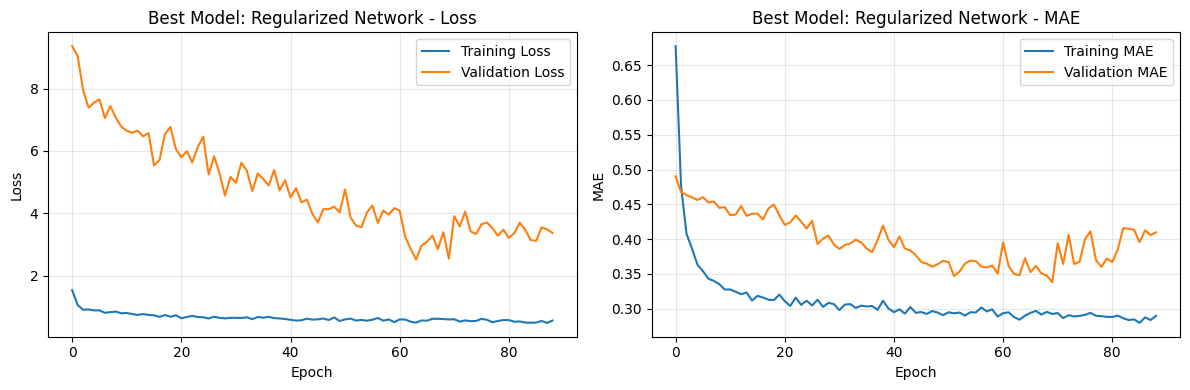

In [104]:
results, best_arch, data = run_deep_learning_experiments(df_enhanced, optimized_features, epochs=300)